# PyTorch

### Урок 2. CNN and LSTM for human action recognition

In [1]:
import sys
import numpy as np
import pandas as pd
import time
import math
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
print("Python : %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python : 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
Pytorch: 1.6.0


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
scaler = StandardScaler()
# Функция нормализации
def norm_transform(x):
    return scaler.fit_transform(x)

In [5]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
#       self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [6]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.data.iloc[idx,-1]
        if self.transform != None:
            item = self.transform(item)

        return (item, label)

In [7]:
skeletons = pd.read_csv("test_skels.csv")

In [8]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,0.218115,0.172597,3.785547,0.232329,0.432664,3.714767,0.245780,0.687725,3.633897,0.212851,...,0.225672,0.433790,3.553600,0.134513,0.665350,3.444698,0.148858,0.627080,3.448667,0
1,0.224268,0.185463,3.789091,0.238113,0.442199,3.710211,0.249919,0.692741,3.619438,0.209501,...,0.149702,0.328782,3.524357,0.139918,0.812734,3.457869,0.118585,0.754463,3.439572,0
2,0.166643,0.169332,3.764293,0.182184,0.430023,3.690497,0.196409,0.685314,3.606696,0.157366,...,-0.021367,0.162484,3.878167,0.128432,0.729048,3.451543,0.130322,0.707719,3.402800,1
3,0.156408,0.167995,3.780114,0.174070,0.428376,3.704427,0.189149,0.683577,3.618258,0.143667,...,0.020917,0.141005,3.853444,0.171469,0.732059,3.466049,0.222878,0.696383,3.413667,1
4,0.195193,0.196150,3.817392,0.208243,0.449287,3.735566,0.221046,0.697232,3.643296,0.191088,...,-0.050044,0.671995,3.659500,0.054728,0.618219,3.549659,0.096540,0.627727,3.503273,2


In [9]:
skeletons.labels.unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [10]:
LABELS = {0: 'drink water', 1: 'brush teeth', 2: 'brush hair', 3: 'throw', 
          4: 'sit down', 5: 'clapping', 6: 'tear up paper', 7: 'put on glasses'}

In [11]:
dataset = Skeleton_Dataset(file_path = "test_skels.csv", transform=norm_transform)
skel, lab = dataset.__getitem__(13)

In [12]:
skel.shape

(45, 75)

In [13]:
skel

array([[-2.13784436e-01,  2.38475611e-01, -7.55888367e-01, ...,
         4.08695591e-03, -2.57278993e-01, -1.97090515e+00],
       [-3.36257114e-01,  8.31122661e-02, -9.43178534e-01, ...,
         3.03837785e-01, -3.34772735e-01, -1.29458454e+00],
       [-3.32476494e-01,  8.89520591e-02, -9.44223388e-01, ...,
        -5.09146226e-01, -1.05431560e+00, -1.39293229e+00],
       ...,
       [-2.02159904e+00,  1.55638023e+00, -2.20922871e-01, ...,
        -4.94226730e-01, -2.10439752e-02,  5.17678077e-01],
       [-2.03265008e+00,  1.49882720e+00,  1.63113395e-03, ...,
        -3.48474085e-01, -4.24137902e-02,  1.05253388e+00],
       [-1.35502739e+00,  1.61142338e+00,  5.77084741e-01, ...,
        -5.97045272e-01,  1.00586639e+00,  1.01275850e+00]])

In [14]:
LABELS[lab]

'brush teeth'

In [15]:
ALL_LEN = len(dataset)
# 30% - тестовые данные
TEST_LEN  = int(0.3 * ALL_LEN)
# 70% - тренировочные данные
TRAIN_LEN = ALL_LEN - TEST_LEN
print(f'ALL_LEN = {ALL_LEN}, TEST_LEN = {TEST_LEN}, TRAIN_LEN = {TRAIN_LEN}')

ALL_LEN = 1164, TEST_LEN = 349, TRAIN_LEN = 815


In [16]:
BATCH = 16
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [TRAIN_LEN, TEST_LEN])
train_loader = DataLoader(train_dataset, batch_size = BATCH, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size = BATCH, shuffle=True)

In [17]:
n_hidden = 128
n_joints = 25 * 3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [18]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m:02.0f}m {s:02.0f}s'

In [19]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()
sket_tensor.size()

torch.Size([1, 45, 75])

In [20]:
output = rnn(sket_tensor.to(device))
output.topk(5)

torch.return_types.topk(
values=tensor([[0.0457, 0.0448, 0.0329, 0.0321, 0.0172]], device='cuda:0',
       grad_fn=<TopkBackward>),
indices=tensor([[7, 1, 3, 4, 2]], device='cuda:0'))

<IPython.core.display.Javascript object>


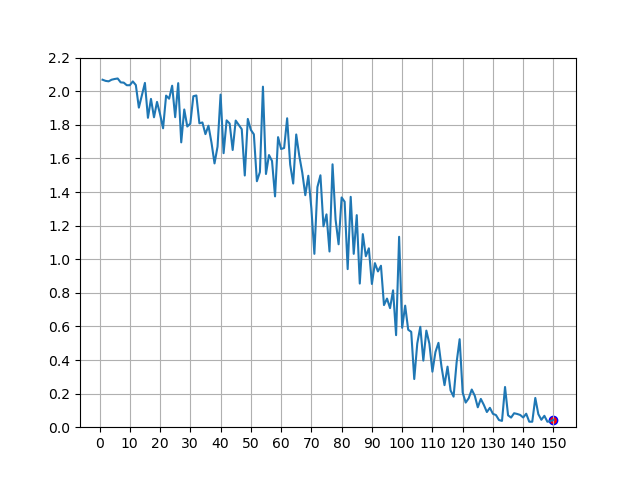

Epoch :   0 iter :  0 (00m 00s) 2.073238 | brush hair ✗ (tear up paper)
Epoch :   9 iter : 41 (00m 55s) 2.010891 | sit down ✓
Epoch :  19 iter : 31 (01m 50s) 1.984438 | sit down ✗ (drink water)
Epoch :  29 iter : 21 (02m 46s) 1.844518 | clapping ✗ (put on glasses)
Epoch :  39 iter : 11 (03m 41s) 1.556370 | sit down ✓
Epoch :  49 iter :  1 (04m 36s) 1.543859 | drink water ✗ (brush hair)
Epoch :  58 iter : 42 (05m 31s) 1.474311 | clapping ✓
Epoch :  68 iter : 32 (06m 26s) 1.243921 | put on glasses ✓
Epoch :  78 iter : 22 (07m 21s) 1.480691 | tear up paper ✓
Epoch :  88 iter : 12 (08m 16s) 0.883715 | drink water ✓
Epoch :  98 iter :  2 (09m 11s) 1.013096 | brush hair ✓
Epoch : 107 iter : 43 (10m 05s) 0.459907 | sit down ✓
Epoch : 117 iter : 33 (10m 59s) 0.203734 | throw ✓
Epoch : 127 iter : 23 (11m 53s) 0.080755 | clapping ✓
Epoch : 137 iter : 13 (12m 47s) 0.082217 | brush teeth ✓
Epoch : 147 iter :  3 (13m 41s) 0.037000 | clapping ✓


In [21]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0

EPOCHS = 150
xlist = np.arange(1,EPOCHS+1)
ylist = [0 for _ in np.arange(1,EPOCHS+1)]
fig = plt.figure()
ax = fig.add_subplot(111)

plt.ion()

for epoch in range(EPOCHS):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        ##### Cделать обновление графика loss по ходу обучению
        ax.clear()
        ylist[epoch] = loss.item()
        ax.set_ylim(0, 2)
        ax.set_yticks(np.arange(0, 2.4, 0.2))
        ax.set_xticks(np.arange(0, EPOCHS+1, 10))
        ax.grid(True)
        ax.plot(xlist, ylist)
        ax.scatter(epoch+1, loss.item(), marker='o', c='r', edgecolor='b')
        fig.canvas.draw()        

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            
            ##### Cделать более аккуратный вывод для каждой эпохи
            print(f'Epoch : {epoch:3d} iter : {i:2d} ({timeSince(start)}) {loss:.6f} | {guess} {correct}')
        
        counter = counter + 1

    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
        
plt.ioff()

#### Датасет с 30-ю кадрами в серии

In [22]:
skeletons = pd.read_csv("test_skels_30.csv")

In [23]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,...,2241,2242,2243,2244,2245,2246,2247,2248,2249,labels
0,0.218115,0.172597,3.785547,0.232329,0.432664,3.714767,0.245780,0.687725,3.633897,0.212851,...,0.185337,0.404900,3.510472,0.079967,0.461626,3.484977,0.105123,0.422496,3.501889,0
1,0.217372,0.180680,3.794905,0.235477,0.437788,3.724968,0.253172,0.690464,3.645268,0.217930,...,0.218127,0.441380,3.578334,0.162369,0.737223,3.458747,0.164917,0.690779,3.428000,0
2,0.223145,0.192968,3.791842,0.246188,0.446711,3.714186,0.269118,0.695470,3.625993,0.200502,...,0.149702,0.328782,3.524357,0.139918,0.812734,3.457869,0.118585,0.754463,3.439572,0
3,0.166643,0.169332,3.764293,0.182184,0.430023,3.690497,0.196409,0.685314,3.606696,0.157366,...,0.031883,0.159993,3.751909,0.131571,0.697192,3.410052,0.162340,0.673121,3.346429,1
4,0.159635,0.166874,3.777391,0.180222,0.431855,3.701943,0.199785,0.691840,3.616520,0.157087,...,-0.033375,0.134545,3.834167,0.157068,0.721542,3.460548,0.152638,0.697433,3.408889,1


In [24]:
skeletons.labels.unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [25]:
class Skeleton_Dataset30(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(30,75)
        label = self.data.iloc[idx,-1]
        if self.transform != None:
            item = self.transform(item)

        return (item, label)

In [26]:
dataset = Skeleton_Dataset30(file_path = "test_skels_30.csv", transform=norm_transform)
skel, lab = dataset.__getitem__(13)

In [27]:
skel.shape

(30, 75)

In [28]:
ALL_LEN = len(dataset)
# 30% - тестовые данные
TEST_LEN  = int(0.3 * ALL_LEN)
# 70% - тренировочные данные
TRAIN_LEN = ALL_LEN - TEST_LEN
print(f'ALL_LEN = {ALL_LEN}, TEST_LEN = {TEST_LEN}, TRAIN_LEN = {TRAIN_LEN}')

ALL_LEN = 1213, TEST_LEN = 363, TRAIN_LEN = 850


In [29]:
BATCH = 16
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [TRAIN_LEN, TEST_LEN])
train_loader = DataLoader(train_dataset, batch_size = BATCH, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size = BATCH, shuffle=True)

In [30]:
n_hidden = 128
n_joints = 25 * 3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [31]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()
sket_tensor.size()

torch.Size([1, 30, 75])

In [32]:
output = rnn(sket_tensor.to(device))
output.topk(8)

torch.return_types.topk(
values=tensor([[ 0.0751,  0.0036, -0.0042, -0.0525, -0.0544, -0.0594, -0.0713, -0.1100]],
       device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[1, 4, 2, 7, 6, 0, 5, 3]], device='cuda:0'))

<IPython.core.display.Javascript object>


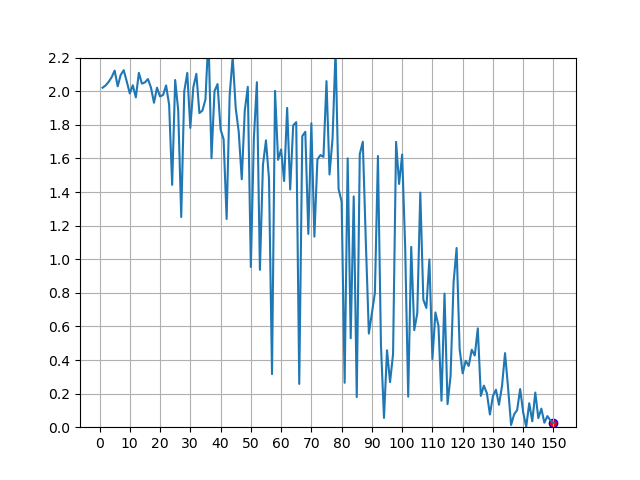

Epoch :   0 iter :  0 (00m 00s) 2.058366 | brush teeth ✗ (tear up paper)
Epoch :   9 iter : 14 (00m 52s) 2.058335 | sit down ✗ (drink water)
Epoch :  18 iter : 28 (01m 43s) 1.958295 | brush teeth ✗ (throw)
Epoch :  27 iter : 42 (02m 34s) 1.674065 | sit down ✗ (throw)
Epoch :  37 iter :  2 (03m 26s) 1.725423 | brush teeth ✗ (put on glasses)
Epoch :  46 iter : 16 (04m 18s) 1.777080 | sit down ✗ (drink water)
Epoch :  55 iter : 30 (05m 09s) 1.938591 | clapping ✗ (tear up paper)
Epoch :  64 iter : 44 (06m 00s) 1.317440 | brush teeth ✓
Epoch :  74 iter :  4 (06m 52s) 1.292932 | sit down ✓
Epoch :  83 iter : 18 (07m 44s) 1.327750 | sit down ✓
Epoch :  92 iter : 32 (08m 35s) 0.768608 | sit down ✓
Epoch : 101 iter : 46 (09m 26s) 1.266685 | put on glasses ✗ (clapping)
Epoch : 111 iter :  6 (10m 18s) 0.581081 | brush teeth ✗ (drink water)
Epoch : 120 iter : 20 (11m 09s) 0.526785 | tear up paper ✓
Epoch : 129 iter : 34 (11m 59s) 0.286001 | sit down ✓
Epoch : 138 iter : 48 (12m 50s) 0.274461 | sit

In [34]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0

EPOCHS = 150
xlist = np.arange(1,EPOCHS+1)
ylist = [0 for _ in np.arange(1,EPOCHS+1)]
fig = plt.figure()
ax = fig.add_subplot(111)

plt.ion()

for epoch in range(EPOCHS):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        ##### Cделать обновление графика loss по ходу обучению
        ax.clear()
        ylist[epoch] = loss.item()
        ax.set_ylim(0, 2)
        ax.set_yticks(np.arange(0, 2.4, 0.2))
        ax.set_xticks(np.arange(0, EPOCHS+1, 10))
        ax.grid(True)
        ax.plot(xlist, ylist)
        ax.scatter(epoch+1, loss.item(), marker='o', c='r', edgecolor='b')
        fig.canvas.draw()        

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            
            ##### Cделать более аккуратный вывод для каждой эпохи
            print(f'Epoch : {epoch:3d} iter : {i:2d} ({timeSince(start)}) {loss:.6f} | {guess} {correct}')
        
        counter = counter + 1

    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
        
plt.ioff()

#### Вывод: Уменьшение количества кадров в серии с 45-ти до 30-ти негативно сказалось на качестве обучения.  При идентичных параметрах (скорость обучения, оптимайзер, кол-во эпох обучения) Loss снижался медленнее.